# Считывание данных

Данные представляют собой 900000 наблюдений с 58 признаками, из которых 26 с дискретными значениями. Стоит задача классификации, метки принимают значения 0 и 1, причем задача не сбаласирована: второй класс составляет 30%. Данные анонимизированы. В данных достаточно большое количество пропущенных значений.

In [1]:
import numpy as np
import pandas as pd

In [2]:
X_train = pd.read_csv('xtrain.csv', dtype = 'float32')
X_train.columns = X_train.columns.astype('int8')
X_test = pd.read_csv('xtest.csv', dtype = 'float32')
X_test.columns = X_test.columns.astype('int8')
y_train = pd.read_csv('ytrain.csv')

In [3]:
cat_feat = [2,3,5,6,7,9,10,15,18,21,22,23,24,26,27,29,30,31,32,36,44,45,47,48,50,51]
cat_feat_short = [5,6,10,23, 30,31,44,47,50]
X_train[cat_feat] = X_train[cat_feat].fillna(-1.)
X_train = X_train.fillna(0.)
X_test[cat_feat] = X_test[cat_feat].fillna(-1.)
X_test = X_test.fillna(0.)

In [4]:
y_train['x'].value_counts()

0    623940
1    276060
Name: x, dtype: int64

# Feature selection 

В данных обнаружилась интересная особонность: если произвести отбор признаков нелинейным алгоритмом, то окажется, что существенный вклад вносят только 5 признаков, остальные -- шум. Вот пример отбора признаков с помощью Light GBM.

In [5]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split

X_train_, X_val_, y_train_, y_val_ = train_test_split(
                X_train, y_train['x'].values, test_size=0.20,
                random_state=314, stratify=y_train['x'].values
)

print ('fitting model')
params = {
    'num_leaves': 2**5,
    'objective': 'binary',
    'max_depth': 8,
    'min_data_in_leaf': 50,
    'learning_rate': 0.1,
    'metric': 'auc',
    'num_threads': 8
}

MAX_ROUNDS = 2000

dtrain = lgb.Dataset(X_train_, label=y_train_)
dval = lgb.Dataset(X_val_, label=y_val_, reference=dtrain)

bst = lgb.train(
        params, dtrain, num_boost_round=MAX_ROUNDS,
        valid_sets=[dtrain, dval],  early_stopping_rounds=50, verbose_eval=100
)

fitting model
Training until validation scores don't improve for 50 rounds.
[100]	training's auc: 0.725699	valid_1's auc: 0.71837
[200]	training's auc: 0.744765	valid_1's auc: 0.727016
[300]	training's auc: 0.760682	valid_1's auc: 0.733302
[400]	training's auc: 0.772936	valid_1's auc: 0.735963
[500]	training's auc: 0.784268	valid_1's auc: 0.739496
[600]	training's auc: 0.793917	valid_1's auc: 0.740736
[700]	training's auc: 0.803458	valid_1's auc: 0.743506
[800]	training's auc: 0.81229	valid_1's auc: 0.745941
[900]	training's auc: 0.819803	valid_1's auc: 0.746997
Early stopping, best iteration is:
[878]	training's auc: 0.818238	valid_1's auc: 0.747122


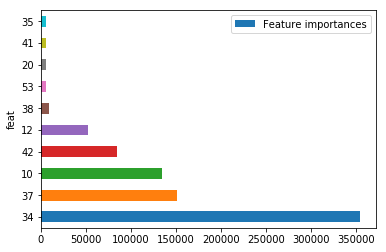

In [6]:
best_feat = [x for x in sorted(
        zip(X_train.columns, bst.feature_importance("gain")),
        key=lambda x: x[1], reverse=True)]

best_feat = pd.DataFrame(best_feat, columns = ['feat','gain'])
best_feat.set_index('feat', inplace=True)
best_feat['gain'].nlargest(10).plot(kind='barh', figsize=(6,4), label = 'Feature importances', legend = True)

На графике видно, что существенный вклад в построение модели вносят только 5 признаков. Из них 4 являются численным и один бинарным. Оставим только эти признаки, так как остальные только затрудняют поиск оптимума для алгоритма.

In [7]:
short_feat_list = best_feat['gain'].nlargest(5).index
X_train = X_train[short_feat_list]
X_test = X_test[short_feat_list]

# Визуализация важных признаков

Посмотрим на графики условных плотностей значений признаков при значении метки 0 и 1, чтобы визуально оценить, есть ли в данных какая-нибудь интересная закономерность.

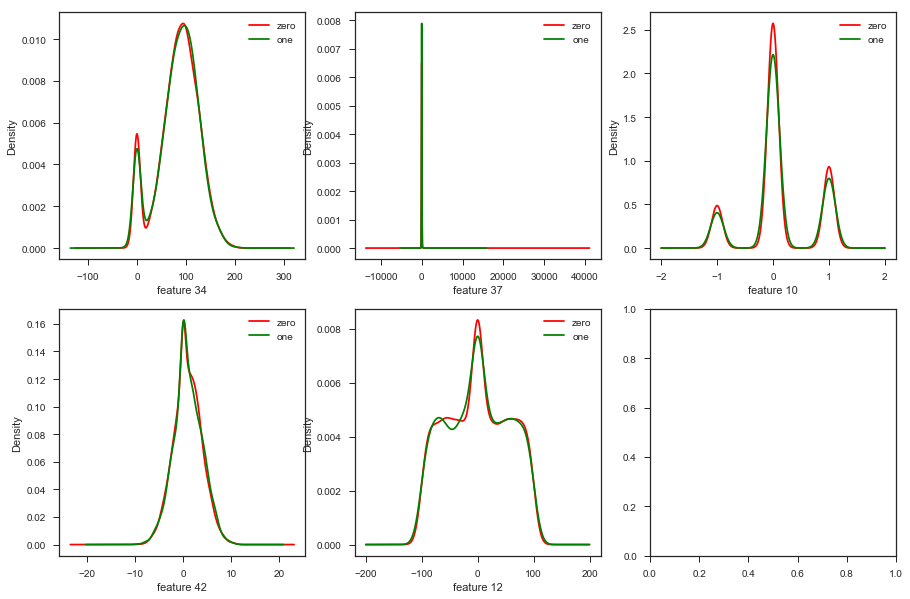

In [88]:
data = X_train.join(y_train)
data = data[:450000]
fig, axes = plt.subplots(nrows = 2, ncols = 3, figsize = (15,10))
for i,t in enumerate(X_train.columns):
    zero = data[t][data['x'] == 0]
    one = data[t][data['x'] == 1]
    ax1 = zero.plot(color = 'r', label = 'zero', kind = 'kde', legend = 'True', ax = axes[int(i/3),i%3])
    one.plot(color = 'g', label = 'one', kind = 'kde', legend = 'True', ax = axes[int(i/3), i%3])
    ax1.set_xlabel('feature %d' % (t))    

На графиках видно, что распределения данных при целевом значении 0 и 1 похожи, наибольшее расхождение как раз в пропущенных значениях (заполнены нулями). При заполнении пропущенных значений другими значениями, качество модели существенно не улучшается.

# Cross-validation

Для построения основной модели будем также использовать LightGBM, так как линейные модели в данном случае плохо восстанавливают структуру данных. С помощью кросс-валидации оценим необходимые параметры модели.

In [33]:
import lightgbm as lgb
print("Cross validation...")

round_list = [2000, 3000, 4000, 5000, 6000, 7000]
learning_rate_list = [0.3, 0.5]
auc_means = []

dtrain = lgb.Dataset(
        X_train[short_feat_list], label=y_train['x'].values
)


for i in learning_rate_list:
    params = {
        'num_leaves': 2**4,
        'objective': 'binary',
        'max_depth': 8,
        'min_data_in_leaf': 50,
        'learning_rate': i,
        'metric': 'auc',
        'num_threads': 8
    }


    for j in round_list:
        MAX_ROUNDS = j

        lgb_cv = lgb.cv(
                params, dtrain, num_boost_round = MAX_ROUNDS, 
                nfold = 5
        )
        #auc_means.append[(i,j,lgb_cv['auc-mean'][-1])]
        print('for learning rate %f, rounds %d roc_auc is %f' %(i,j,lgb_cv['auc-mean'][-1])) 

Cross validation...
for learning rate 0.300000, rounds 2000 roc_auc is 0.782178
for learning rate 0.300000, rounds 3000 roc_auc is 0.783984
for learning rate 0.300000, rounds 4000 roc_auc is 0.784819
for learning rate 0.300000, rounds 5000 roc_auc is 0.785038
for learning rate 0.300000, rounds 6000 roc_auc is 0.784850
for learning rate 0.300000, rounds 7000 roc_auc is 0.784422
for learning rate 0.500000, rounds 2000 roc_auc is 0.780133
for learning rate 0.500000, rounds 3000 roc_auc is 0.780392
for learning rate 0.500000, rounds 4000 roc_auc is 0.779535
for learning rate 0.500000, rounds 5000 roc_auc is 0.778570
for learning rate 0.500000, rounds 6000 roc_auc is 0.777656
for learning rate 0.500000, rounds 7000 roc_auc is 0.776515


Лучший результат показывает модель с шагом 0.3, количеством итераций 5000. С ее помощью мы и построим основную модель.

# Обучение модели

Обучение модели на 80% размеченной выборки, валидация на оставшихся 20%.

In [34]:
from sklearn.model_selection import train_test_split

X_train_, X_val_, y_train_, y_val_ = train_test_split(
                X_train, y_train['x'].values, test_size=0.20,
                random_state=314, stratify=y_train['x'].values
)

In [35]:
print ('fitting model')
params = {
    'num_leaves': 2**4,
    'objective': 'binary',
    'max_depth': 8,
    'min_data_in_leaf': 50,
    'learning_rate': 0.3,
    'metric': 'auc',
    'num_threads': 8
}

dtrain = lgb.Dataset(
        X_train_, label=y_train['x'].values
)

MAX_ROUNDS = 5000

dtrain = lgb.Dataset(
        X_train_, label=y_train_
)
dval = lgb.Dataset(
        X_val_, label=y_val_, reference=dtrain
)

bst = lgb.train(
        params, dtrain, num_boost_round=MAX_ROUNDS,
        valid_sets=[dtrain, dval], verbose_eval=1000
)

fitting model
[1000]	training's auc: 0.816106	valid_1's auc: 0.778167
[2000]	training's auc: 0.845603	valid_1's auc: 0.783437
[3000]	training's auc: 0.864753	valid_1's auc: 0.78552
[4000]	training's auc: 0.879427	valid_1's auc: 0.785609
[5000]	training's auc: 0.89142	valid_1's auc: 0.785899


Качество ROC_AUC на валидационной выборке составило 0.7859.

Построение прогноза для тестовой выборки.

In [37]:
test_pred = []
test_pred.append(bst.predict(X_test, num_iteration=MAX_ROUNDS))
test_pred

[array([0.30837107, 0.0089544 , 0.94913968, ..., 0.43374525, 0.90434915,
        0.32923666])]

In [38]:
#запись прогноза в файл
y_test_pred = pd.DataFrame(test_pred).transpose()
y_test_pred.to_csv('y_pred.csv', index = None, header = None)